In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
df_init = pd.read_csv('data_v1.csv', sep=';')
df_init.head()

Id       Number  Result  Feature_1  Feature_2  Feature_3  Feature_4  \
0   1  10359/C2020       2          2         56         12          1   
1   2  10346/C2020       2          2         69         19          1   
2   3  10311/C2020       2          1         66          8          1   
3   4  10292/C2020       2          2         62         16          1   
4   5  10283/C2020       2          2         67         30          1   

   Feature_5  Feature_6  Feature_106  ...  Feature_99  Feature_100  \
0        7.0          4            2  ...         0.0          0.0   
1        6.0          4            2  ...         0.0          0.0   
2        4.0          4            2  ...         0.0          0.0   
3        NaN          3            2  ...         0.0          0.0   
4        NaN          4            2  ...         0.0          0.0   

   Feature_111  Feature_1122  Feature_112  Feature_113  Feature_114  \
0            1             0            1            1          1.0   
1            1             0            1            1          1.0   
2            1             0            1            1          1.0   
3            1             0            1            1          0.0   
4            1             0            1            1          1.0   

   Feature_115  Feature_116  Feature_117  
0            1            1            0  
1            0            1            1  
2            0            1            0  
3            0            1            1  
4            0            1            0  

[5 rows x 117 columns]

In [30]:
def distrib_plot(df: pd.DataFrame, f: str, y: str):
    x_mean_class_0 = round(df[df[y] == 0][f].mean(), 2)
    x_mean_class_1 = round(df[df[y] == 1][f].mean(), 2)

    plt.figure(figsize = (20, 5))

    sns.distplot(df[df[y] == 0][f], hist=False, color='orange')
    sns.distplot(df[df[y] == 1][f], hist=False, color='blue')

    plt.axvline(x_mean_class_0, label=f'class_0={x_mean_class_0}', color='orange', linestyle=':')
    plt.axvline(x_mean_class_1, label=f'class_1={x_mean_class_1}', color='blue', linestyle='--')

    plt.title(f'Distribution of {f}')
    plt.legend()

In [31]:
def train(df, trash_features = []):

    df_ = df.copy()

    target_feature = 'Result'

    usefull_features = []
    useless_features = ['Id', 'Number', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_17', 'Feature_18', 'Feature_23', 
                        'Feature_29', 'Feature_30', 'Feature_32','Feature_33', 'Feature_34',
                        'Feature_35', 'Feature_54', 'Feature_94', 'Feature_101', 'Feature_108','Feature_111', 
                        'Feature_112','Feature_113', 'Feature_114','Feature_115', 'Feature_116', 'Feature_117']
    
    features_to_drop = [target_feature] + useless_features
    for feature in trash_features:
        if feature not in usefull_features and feature not in useless_features:
            features_to_drop.append(feature)

    all_features = df_.columns.drop(features_to_drop).tolist()

    df_ = df_[[target_feature] + all_features]

    num_features = ['Feature_2', 'Feature_3', 'Feature_33', 'Feature_34', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 
                    'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 
                    'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                    'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']
    
    special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 
                        'Feature_78', 'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 
                        'Feature_85', 'Feature_86', 'Feature_87', 'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 
                        'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 
                        'Feature_99', 'Feature_100']
    
    for col in special_features:
        if col in df_.columns:
            df_[col].fillna(0, inplace=True)

    cat_features = []
    for col in df_.drop(target_feature, axis=1).columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col] = df_[col].astype('float64')
        else:
            cat_features.append(col)
            df_[col].fillna(-1, inplace=True)
            df_[col] = df_[col].astype('int64')
    
    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 0
    df_.loc[df_[target_feature] == 2, target_feature] = 1

    df_train, df_test = train_test_split(
        df_,
        shuffle=True,
        test_size=0.25,
        random_state=0,
        stratify=df_[target_feature],
    )

    # Separate majority and minority classes
    df_majority = df_train[df_train[target_feature] == 1]
    df_minority = df_train[df_train[target_feature] == 0]
    
    # Upsample majority class
    df_majority_upsampled = resample(
        df_majority,
        replace=True,
        n_samples=100,
        random_state=0,
    )
    # Upsample minority class
    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=100,
        random_state=0,
    )
    # Combine minority class with downsampled majority class
    df_train_sampled = pd.concat([df_majority_upsampled, df_minority_upsampled])

    X_train = df_train_sampled[all_features]
    y_train = df_train_sampled[target_feature]

    X_test = df_test[all_features]
    y_test = df_test[target_feature]

    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_features
    )

    params_frozen = {
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
        'one_hot_max_size': 20
    }

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 600, 800, 1000, 1200],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2, 2.5],
        'random_strength': [1, 1.5, 2]
    }

    clf = CatBoostClassifier(**params_frozen)
    rs = clf.randomized_search(
        params_grid,
        train_pool,
        n_iter=5,
        shuffle=True,
        stratified=True,
        partition_random_seed=0,
        cv=5,
        calc_cv_statistics=False,
        search_by_train_test_split=False,
        refit=True,
    )

    return clf, df_, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature

In [32]:
trash_features = []
epochs = 5
for epoch in range(1, epochs+1):

    print(f"\nEpoch {epoch} from {epochs}\n{'=' * 50}")

    clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
        df_init,
        trash_features=trash_features,
    )

    test_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_features
    )
    y_test_pred = clf.predict(test_pool)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf.get_feature_importance()),
        columns=['feature_name', 'importance']
    )

    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    features = feature_importances[feature_importances['importance'] < 1 ]['feature_name'].tolist()
    if trash_features:
        if not features:
            print('Train stopped')
            break

        for feature in features:
            if feature not in trash_features:
                trash_features.append(feature)
    else:
        trash_features=features

    print('Fetures to drop')
    print(trash_features)


Epoch 1 from 5
Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.9300000	best: 0.9300000 (0)	total: 11.5s	remaining: 46.1s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.9150000	best: 0.9300000 (0)	total: 27s	remaining: 40.6s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.8900000	best: 0.9300000 (0)	total: 48.1s	remaining: 32.1s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.9050000	best: 0.9300000 (0)	total: 1m 1s	remaining: 15.3s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8800000	best: 0.9300000 (0)	total: 1m 21s	remaining: 0us
Accuracy: 0.82
F1 Score: 0.81

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        31
           1       0.85      0.77      0.81        30

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82  

In [33]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

for feature in feature_importances[20:]['feature_name'].tolist():
    if feature not in trash_features:
        trash_features.append(feature)

In [34]:
clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
    df_init,
    trash_features=trash_features,
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)
y_test_pred = clf.predict(test_pool)
y_test_pred_proba = clf.predict_proba(test_pool)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.9200000	best: 0.9200000 (0)	total: 6.74s	remaining: 27s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.9000000	best: 0.9200000 (0)	total: 15.2s	remaining: 22.8s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.9300000	best: 0.9300000 (2)	total: 29.8s	remaining: 19.9s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.9350000	best: 0.9350000 (3)	total: 40.3s	remaining: 10.1s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8950000	best: 0.9350000 (3)	total: 55.3s	remaining: 0us
Accuracy: 0.8
F1 Score: 0.79

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        31
           1       0.82      0.77      0.79        30

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



In [35]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

feature_name  importance
14   Feature_63   19.254627
12   Feature_51   10.184427
4    Feature_31    9.953879
9    Feature_47    6.199834
7    Feature_41    5.675480
16   Feature_70    5.480109
1     Feature_6    5.289472
6    Feature_40    5.213780
0     Feature_2    3.926846
11   Feature_49    3.823979
13   Feature_59    3.591721
8    Feature_46    3.449660
19   Feature_73    3.214108
17   Feature_71    2.965841
2     Feature_9    2.623370
3    Feature_28    2.597936
18   Feature_72    2.270216
10   Feature_48    1.825680
5    Feature_37    1.512772
15   Feature_65    0.946263

## Shapley values: features importance

In [36]:
explainer = shap.TreeExplainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

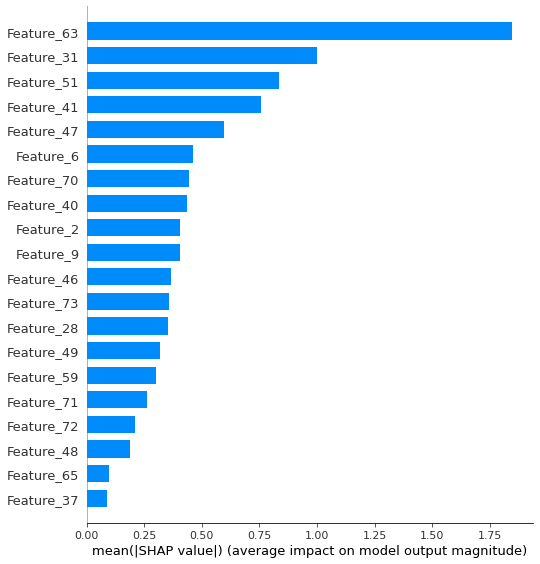

In [37]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", max_display=20)

## Shapley values: summary plot

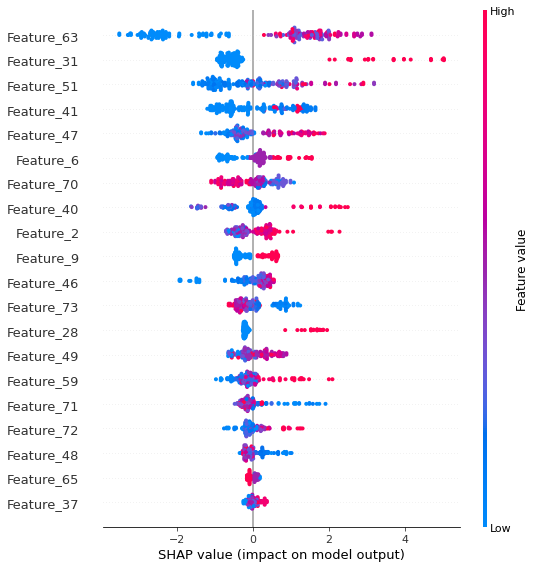

In [38]:
shap.summary_plot(shap_values_train, X_train, max_display=20)

## Features distribution by classes

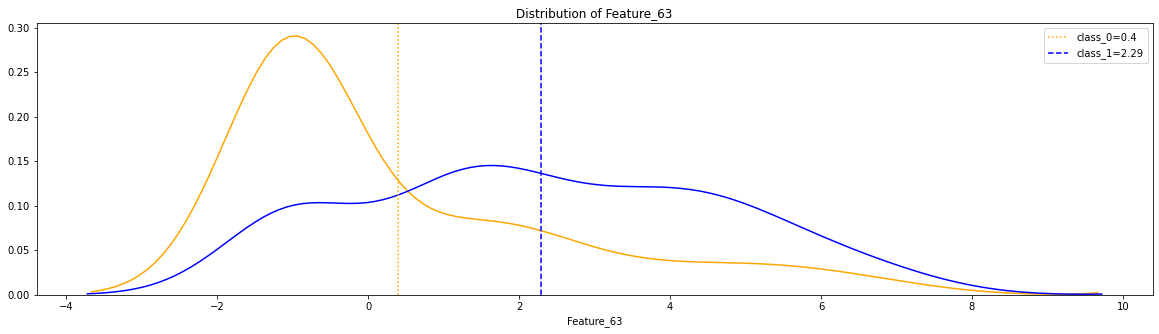

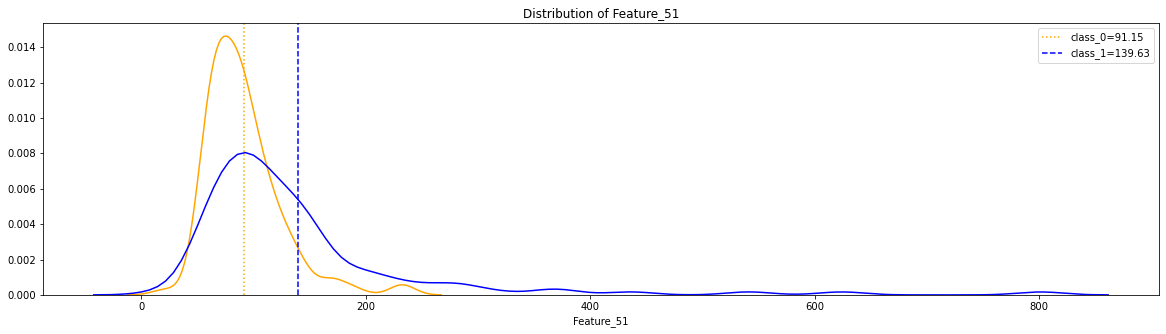

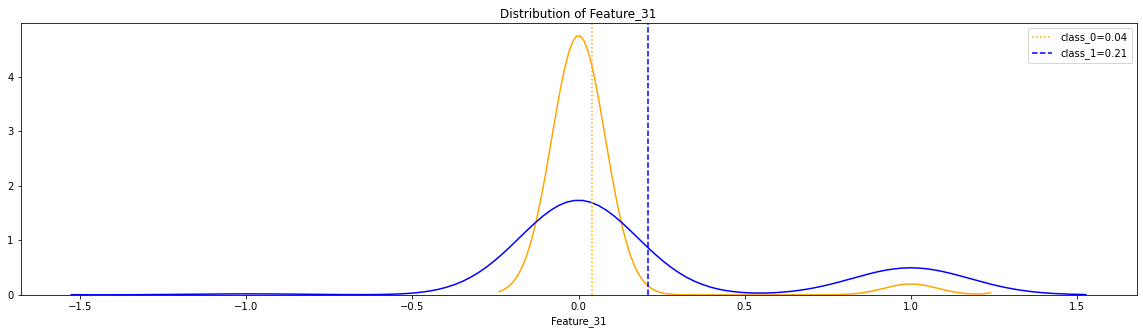

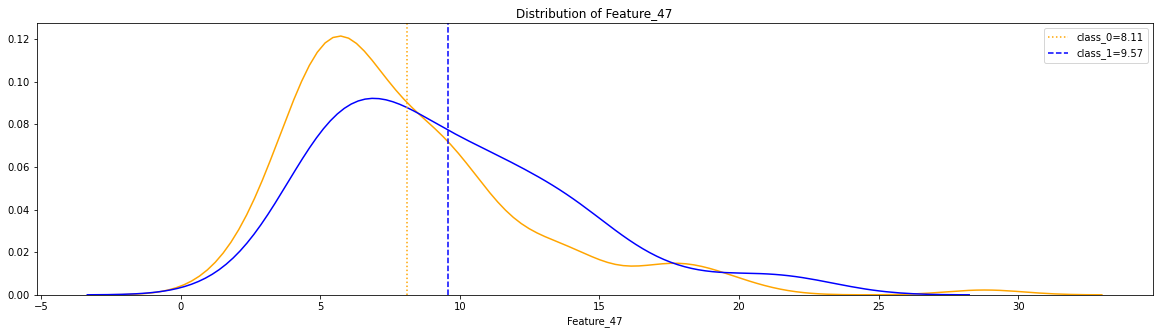

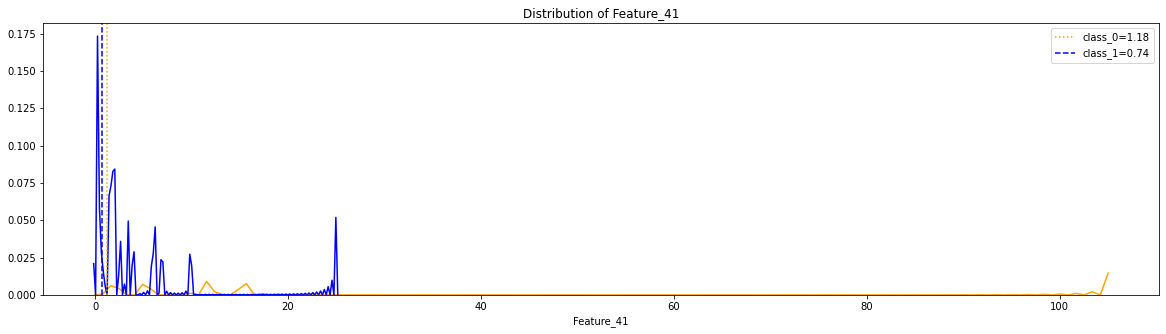

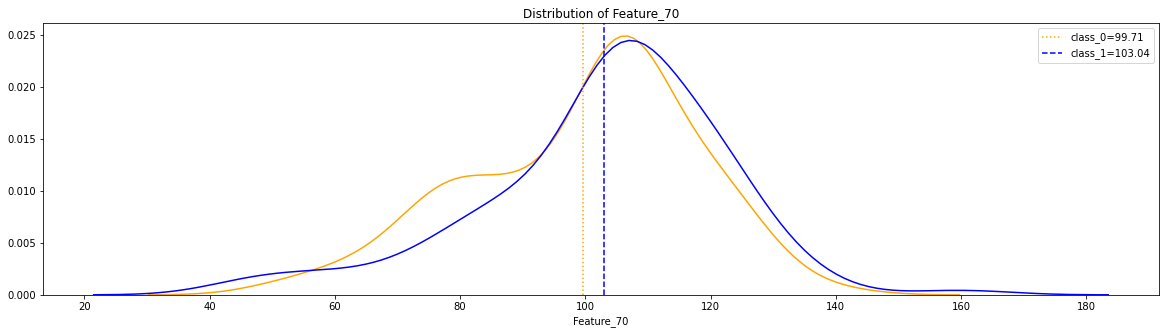

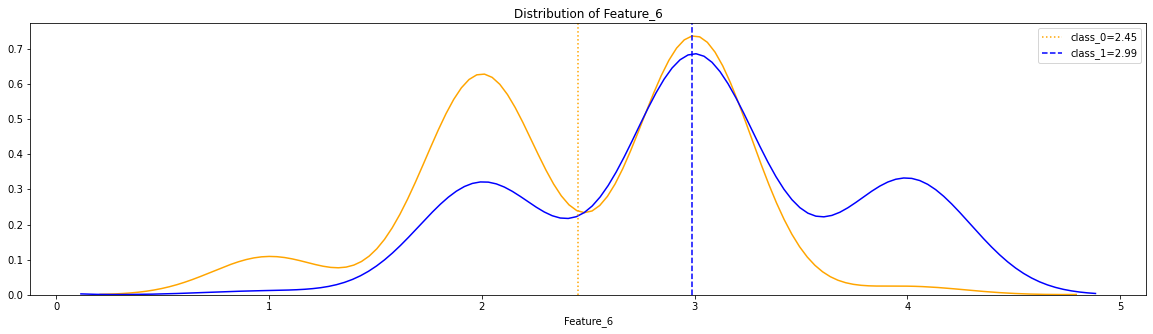

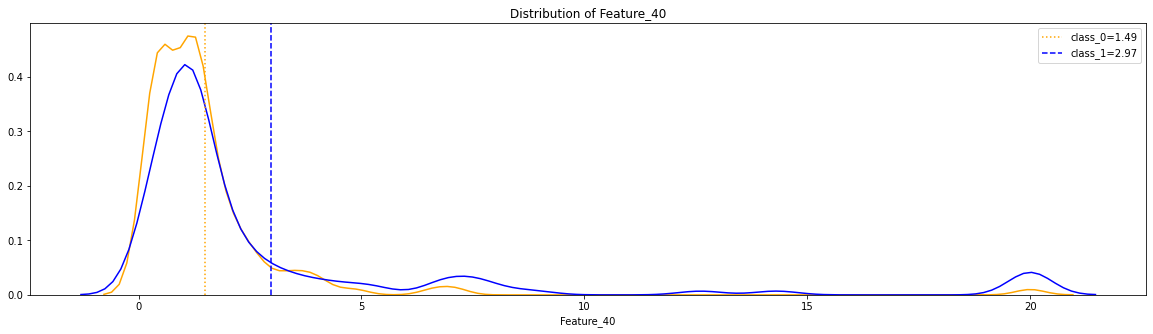

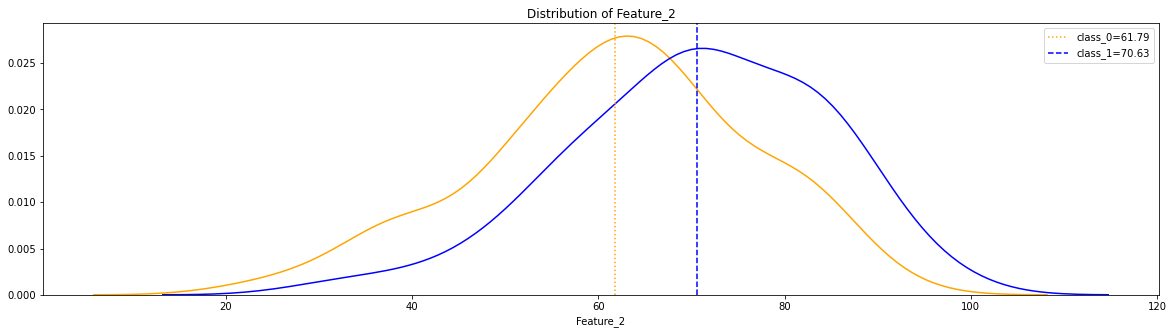

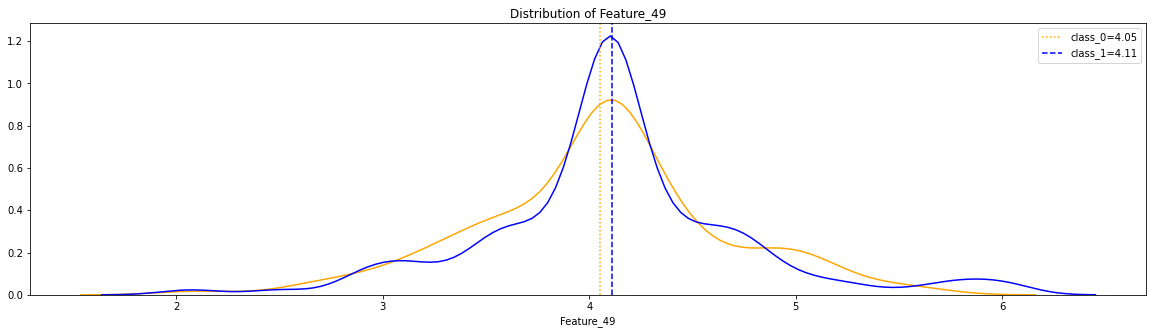

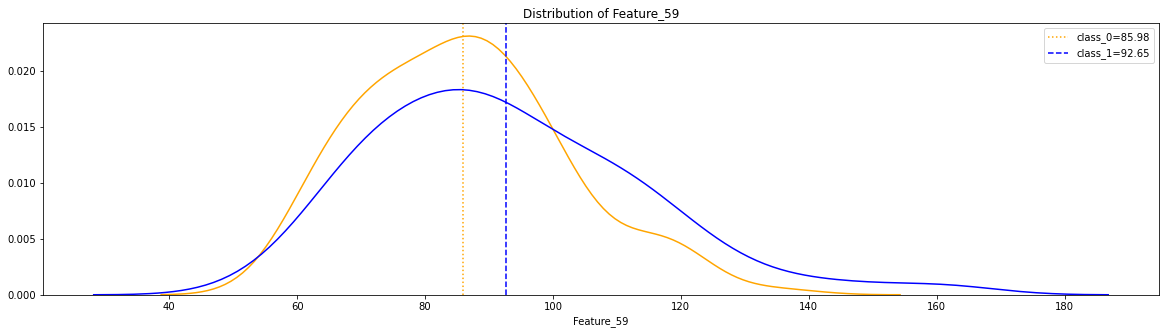

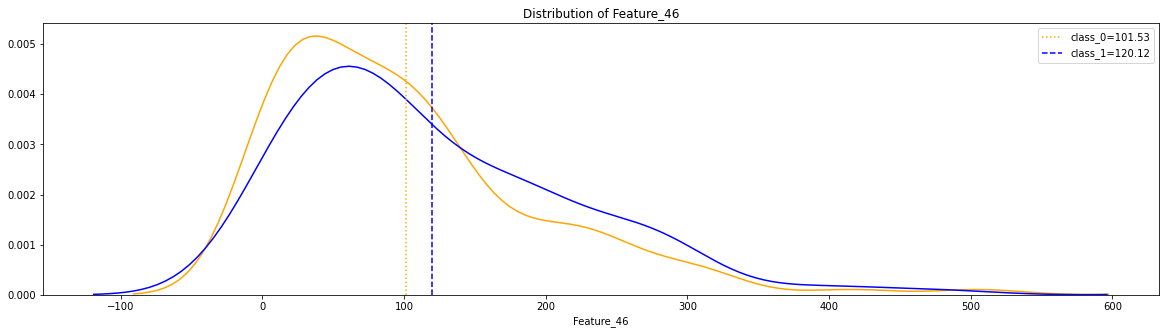

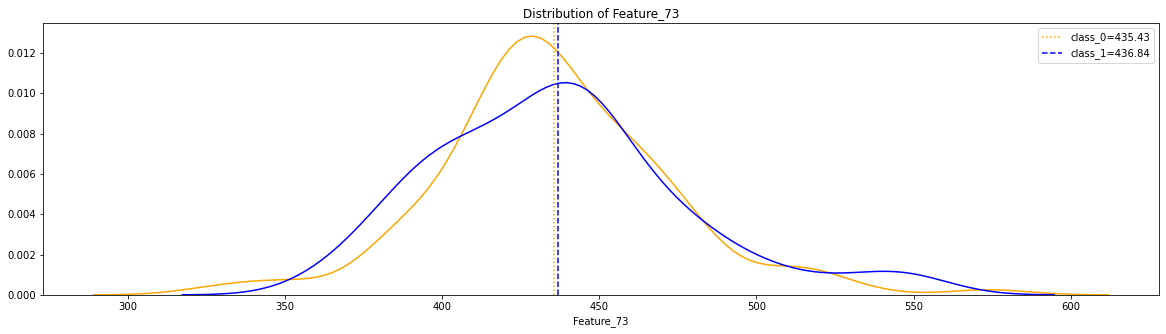

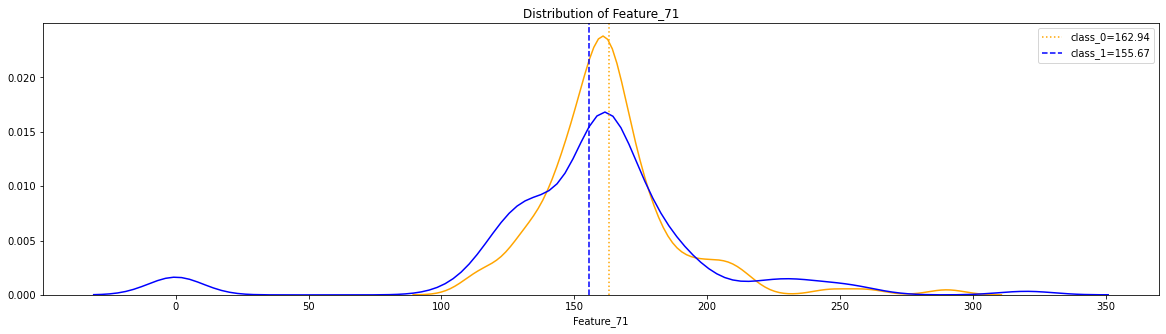

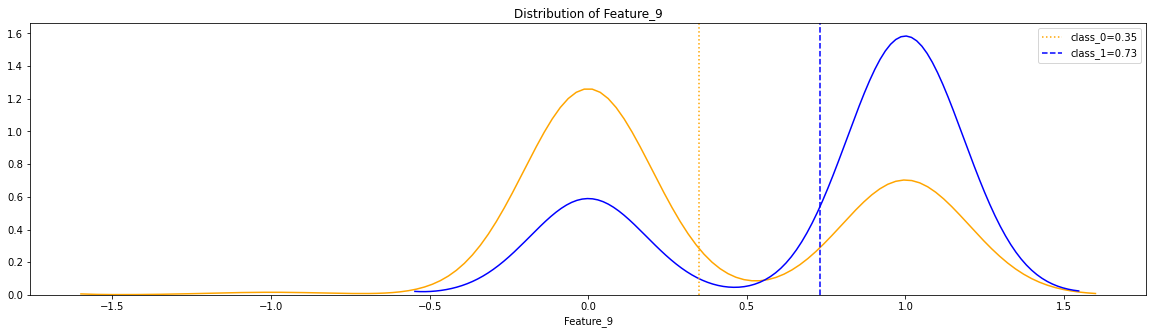

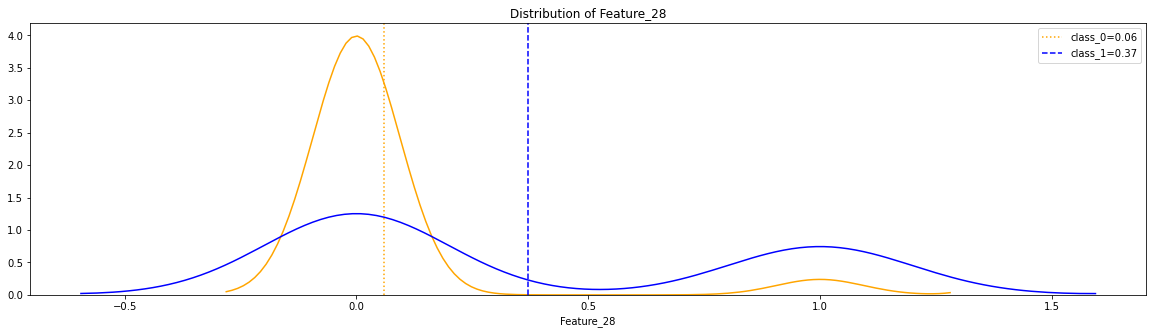

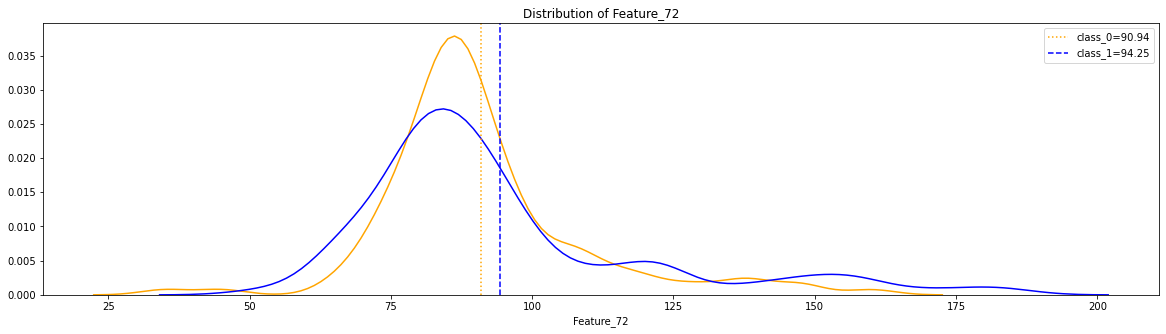

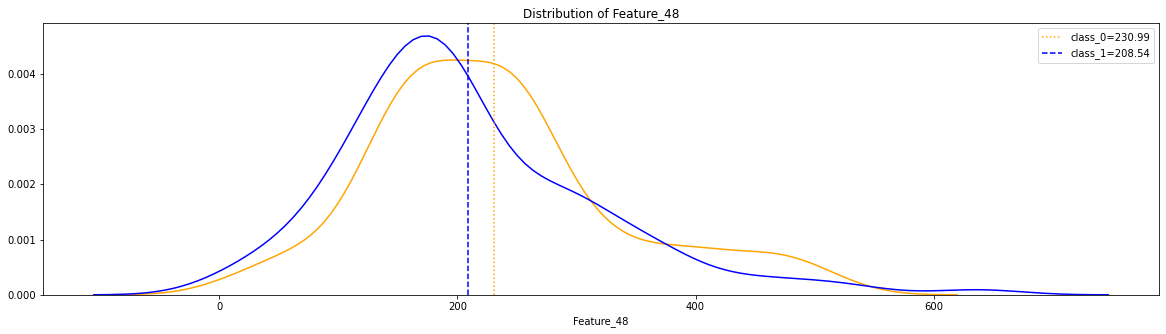

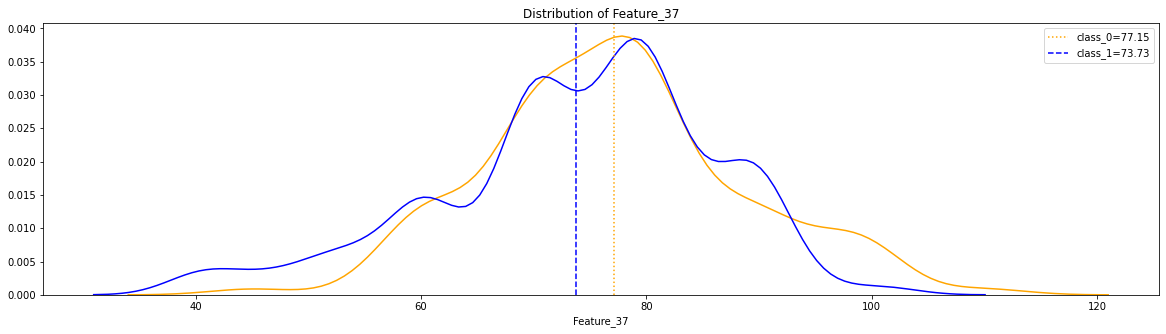

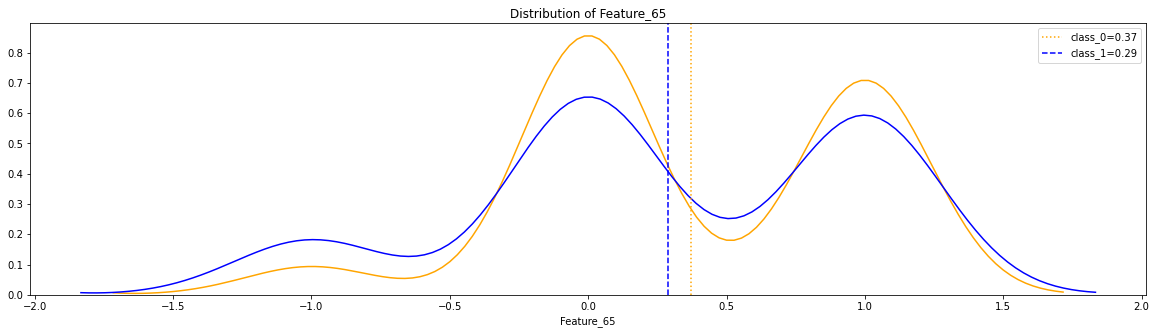

In [39]:
for feature in feature_importances['feature_name']:
    distrib_plot(df, feature, 'Result')

## Errors

In [40]:
df_explain_table = X_test.copy()
df_explain = X_test.copy()

df_explain_table['Result_true'] = y_test
df_explain_table['Result_pred'] = y_test_pred
df_explain_table['Result_pred_proba'] = y_test_pred_proba[:, 1:2]

In [41]:
df_errors = df_explain_table[df_explain_table['Result_true'] != df_explain_table['Result_pred']]
df_errors.T

143         35          82         43          86   \
Feature_2           60.000000   69.000000   49.000000   61.00000   82.000000   
Feature_6            3.000000    2.000000    3.000000    3.00000    2.000000   
Feature_9            1.000000    0.000000    0.000000    1.00000    1.000000   
Feature_28           1.000000    0.000000    0.000000    0.00000    0.000000   
Feature_31           0.000000    0.000000    0.000000    0.00000    0.000000   
Feature_37          90.000000   80.000000   60.000000   86.00000   60.000000   
Feature_40          20.000000    0.490000    2.490000    3.21000    5.120000   
Feature_41           6.200000    0.020000    0.030000    0.07000    0.020000   
Feature_46         286.000000   81.840000  243.580000   93.44000    2.210000   
Feature_47          10.600000    2.600000    6.000000    5.20000    6.800000   
Feature_48         190.000000  210.000000  289.000000  184.00000  178.000000   
Feature_49           3.000000    4.000000    4.700000    4.10000    3.900000   
Feature_51          83.000000   57.200000   59.000000  313.00000   58.000000   
Feature_59          66.000000   91.000000   93.000000   75.00000   70.000000   
Feature_63          -1.000000    2.000000    2.000000    2.00000    1.000000   
Feature_65           1.000000    1.000000    1.000000    0.00000    1.000000   
Feature_70         120.000000  106.000000  112.000000  110.00000  120.000000   
Feature_71         162.000000  138.000000  126.000000  176.00000  158.000000   
Feature_72          82.000000   86.000000   95.000000   90.00000   79.000000   
Feature_73         408.000000  426.000000  451.000000  425.00000  405.000000   
Result_true          1.000000    1.000000    1.000000    1.00000    1.000000   
Result_pred          0.000000    0.000000    0.000000    0.00000    0.000000   
Result_pred_proba    0.209974    0.050795    0.055367    0.13768    0.026176   

                          188         220         135         205        62   \
Feature_2           81.000000   67.000000   54.000000   64.000000   79.00000   
Feature_6            3.000000    2.000000    3.000000    3.000000    2.00000   
Feature_9            1.000000    0.000000    0.000000    1.000000    1.00000   
Feature_28           0.000000    0.000000    0.000000    0.000000    1.00000   
Feature_31           1.000000    1.000000    0.000000    1.000000   -1.00000   
Feature_37          70.000000   80.000000   80.000000  100.000000   45.00000   
Feature_40           1.220000    0.270000    1.220000    1.220000    1.22000   
Feature_41           0.030000    0.000000    0.030000    0.050000    0.21000   
Feature_46         174.000000   29.310000  298.790000   53.450000   50.50000   
Feature_47          19.200000    7.000000   12.400000    9.400000   19.20000   
Feature_48         288.000000  195.000000  179.000000  304.000000  279.00000   
Feature_49           3.200000    3.600000    4.000000    4.100000    3.80000   
Feature_51          55.000000  102.000000  137.000000   74.000000   52.00000   
Feature_59          82.000000   83.000000   80.000000   61.000000   88.00000   
Feature_63          -1.000000   -1.000000    5.000000   -1.000000   -1.00000   
Feature_65           0.000000    1.000000    1.000000    1.000000   -1.00000   
Feature_70          95.000000  110.000000  122.000000  115.000000  105.00000   
Feature_71         148.000000  165.000000  179.000000  177.000000  160.00000   
Feature_72          83.000000   81.000000   97.000000  105.000000   87.00000   
Feature_73         383.000000  415.000000  414.000000  433.000000  433.00000   
Result_true          0.000000    0.000000    0.000000    0.000000    1.00000   
Result_pred          1.000000    1.000000    1.000000    1.000000    0.00000   
Result_pred_proba    0.991139    0.773965    0.651579    0.528734    0.11976   

                          67          107  
Feature_2           62.000000   66.000000  
Feature_6            3.000000    2.000000  
Feature_9            0.000000    0.000000  
Feature_

In [42]:
print('Cases in which the model is wrong\n')

for row in df_errors.index:
    print(f'#{row + 1} \t {df_init.iloc[row]["Number"]}')

Cases in which the model is wrong

#144 	 87/C2021
#36 	 10680/C2020
#83 	 11144/C2020
#44 	 10583/C2020
#87 	 11053/C2020
#189 	 12183/C2020
#221 	 12142/C2020
#136 	 10118/C2020
#206 	 11606/C2020
#63 	 11809/C2020
#68 	 11625/C2020
#108 	 10401/C2020


## Confusion matrix

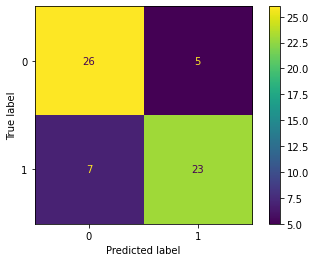

In [43]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))

disp.plot(values_format ='.3g')
plt.show()